# Tracking a computational experiment: conformer generation

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import rdDistGeom
import os
import rdkit
print(rdkit.__version__)
%load_ext sql

2023.03.1


Some data from ChEMBL

In [2]:
import pandas as pd
from io import StringIO
txt = '''"standard_relation","standard_value","standard_type","pchembl_value","assay_chembl_id","target_chembl_id","canonical_smiles","compound_chembl_id"
">",10000.0,"Ki",,"CHEMBL615807","CHEMBL214","CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\C=C/C(=O)O","CHEMBL1794855"
"=",168.0,"Ki",6.78,"CHEMBL615460","CHEMBL214","CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C","CHEMBL278751"
"=",181.0,"Ki",6.74,"CHEMBL615809","CHEMBL214","C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4","CHEMBL103772"
"=",3.9,"Ki",8.41,"CHEMBL615460","CHEMBL214","CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23","CHEMBL328107"
"=",1.6,"Ki",8.8,"CHEMBL615756","CHEMBL214","COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C4)c5csc6ccccc56)Oc12","CHEMBL148860"
"=",210.0,"Ki",6.68,"CHEMBL615460","CHEMBL214","CCCN(CCC)C1CCc2c(C1)ccc3ccoc23","CHEMBL96735"
"=",1.7,"Ki",8.77,"CHEMBL616120","CHEMBL214","CCc1cccc(OC[C@@H](O)CN2CCC3(CC2)OCc4c3ccc5ccccc45)c1","CHEMBL111065"
"=",344.0,"Ki",6.46,"CHEMBL615460","CHEMBL214","CCCN(CCC)C1CCc2c(O)cccc2C1","CHEMBL273273"
"=",127.7,"Ki",6.89,"CHEMBL615756","CHEMBL214","COc1cccc2OC[C@H](CN3C4CCC3C=C(C4)n5ccc6cc(F)ccc56)Oc12","CHEMBL150050"
"=",5.87,"Ki",8.23,"CHEMBL615756","CHEMBL214","CCOc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C4)c5ccc6ccccc6c5)Oc12","CHEMBL151786"
'''
sio = StringIO(txt)
df = pd.read_csv(sio)
df.head()

,standard_relation,standard_value,standard_type,pchembl_value,assay_chembl_id,target_chembl_id,canonical_smiles,compound_chembl_id
0,>,10000.0,Ki,NaN,CHEMBL615807,CHEMBL214,CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\...,CHEMBL1794855
1,=,168.0,Ki,6.78,CHEMBL615460,CHEMBL214,CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C,CHEMBL278751
2,=,181.0,Ki,6.74,CHEMBL615809,CHEMBL214,C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4,CHEMBL103772
3,=,3.9,Ki,8.41,CHEMBL615460,CHEMBL214,CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23,CHEMBL328107
4,=,1.6,Ki,8.80,CHEMBL615756,CHEMBL214,COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C...,CHEMBL148860


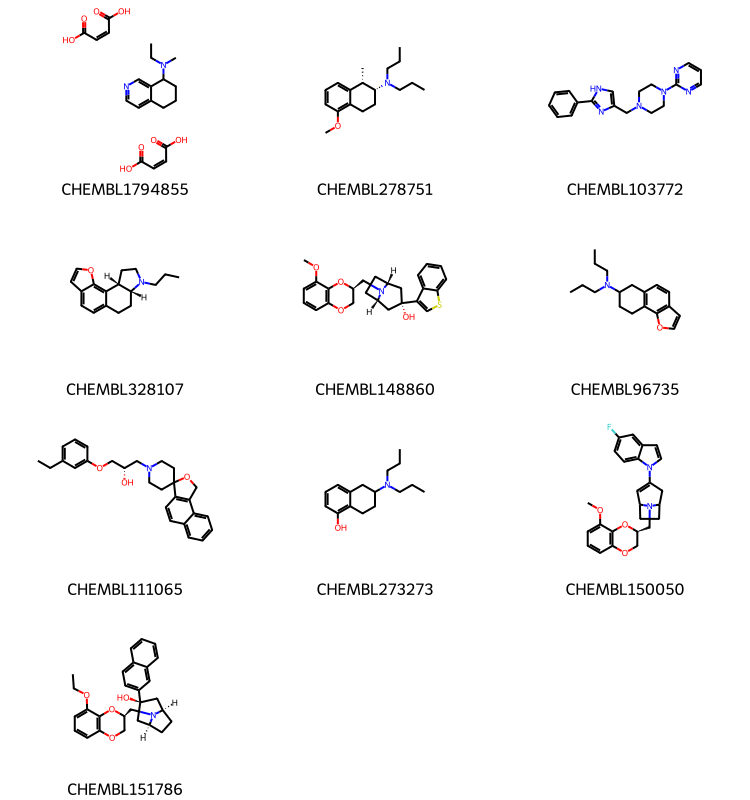

In [3]:
ms = [Chem.MolFromSmiles(smi) for smi in df.canonical_smiles]
Draw.MolsToGridImage(ms,legends=list(df.compound_chembl_id),molsPerRow=3,subImgSize=(250,200))

In [17]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils

config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbtype'] = 'postgresql'
config['dbname'] = 'lwreg_experiments_demo'
# be explicit about what our standardization is:
config['standardization'] = standardization_lib.ChargeParent()


Initialize the database. **Note** that this erases everything in the current database, so be very careful with this command!

In [18]:
lwreg.initdb(config=config,confirm='yes')

True

Register all of our compounds at once:

In [19]:
# The RDKit standardizer is quite verbose by default, make it be quiet:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')

In [20]:
# now bulk register. We want to also collect IDs of compounds which were already registered.
reg_ids = lwreg.bulk_register(mols=ms,config=config,failOnDuplicate=False)
reg_ids = set(reg_ids)
print(f'Registered {len(reg_ids)} unique compounds.')

Registered 10 unique compounds.


Get the registered mol blocks from lwreg.

In [21]:
reg_ids

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

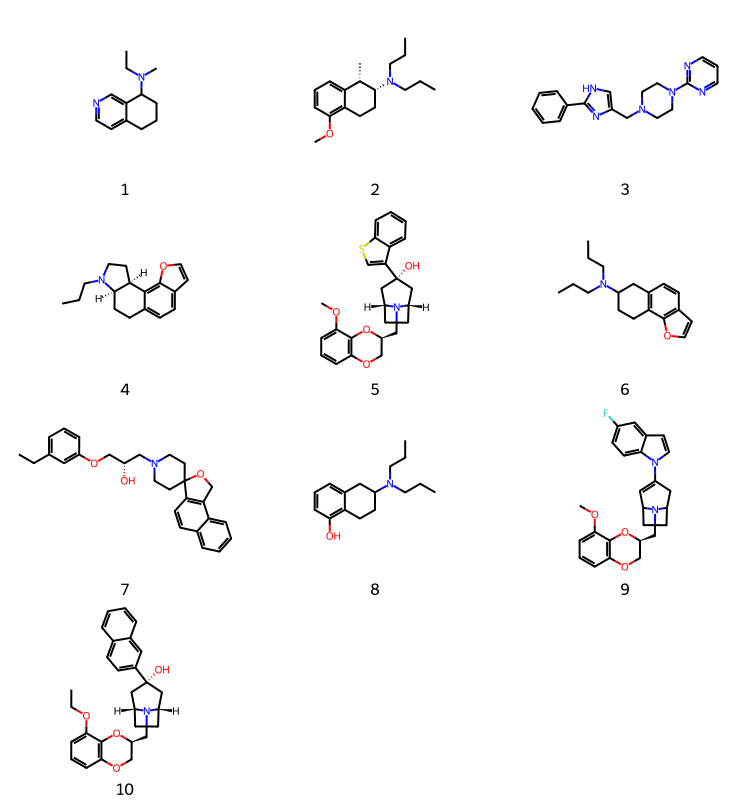

In [22]:
mol_data = lwreg.retrieve(ids=list(reg_ids),config=config)
mids,new_mols = zip(*[(mid,Chem.MolFromMolBlock(d)) for mid,d,_ in mol_data])
Draw.MolsToGridImage(new_mols,legends=[str(x) for x in mids],molsPerRow=3,subImgSize=(250,200))

# Set up database to hold experiments and results:

Initialize the experiment database:

In [23]:
cn = utils._connect(config)
curs = cn.cursor()
curs.execute('create schema if not exists experiments')
curs.execute('drop table if exists experiments.metadata')
curs.execute('create table experiments.metadata (expt_uid text primary key,metadata jsonb)')
curs.execute('drop table if exists experiments.data')
curs.execute('create table experiments.data (expt_uid text not null,molregno int not null,data jsonb)')
cn.commit()

In [24]:
from datetime import datetime
def non_default_params_to_dict(obj,defaults):
    res = {}
    for k in dir(obj):
        if k.startswith('__'):
            continue
        v = getattr(obj,k)
        if callable(v):
            continue
        if v == getattr(defaults,k):
            continue
        else:
            res[k] = v
    return res


# Experiment 1: Generate conformers and store results in files

It's also possible to store the conformers directly in the database; this will be demonstrated in a different notebook.

In [25]:
from rdkit.Chem import rdMolDescriptors
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.numThreads = 8

dg_metadata = non_default_params_to_dict(ps,rdDistGeom.ETKDGv3())

cg_expt_metadata = {
    'Experiment Type':'Conformer generation',
    'Method': 'ETKDGv3',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'target_num_conformers':1,
    'note':'run1: 3D conformers of some ChEMBL molecules + some 3D descriptors'
}
cg_expt_metadata.update(dg_metadata)

In [26]:
m3ds = []
for mid,m in zip(mids,new_mols):
    mh = Chem.AddHs(m)
    cid = rdDistGeom.EmbedMolecule(mh,ps)
    if cid != -1:
        mh.SetDoubleProp('NPR1',rdMolDescriptors.CalcNPR1(mh))
        mh.SetDoubleProp('NPR2',rdMolDescriptors.CalcNPR2(mh))
        mh.SetDoubleProp('RadiusOfGyration',rdMolDescriptors.CalcRadiusOfGyration(mh))
        mh.SetDoubleProp('PBF',rdMolDescriptors.CalcPBF(mh))
        m3ds.append((mid,mh))
        
print(f'got a conformer for {len(m3ds)} of {len(new_mols)} molecules')
    

got a conformer for 10 of 10 molecules


In [27]:
cg_expt_metadata

{'Experiment Type': 'Conformer generation',
 'Method': 'ETKDGv3',
 'RDKit Version': '2023.03.1',
 'Date': '2023-08-30 15:45:03.422733',
 'target_num_conformers': 1,
 'note': 'run1: 3D conformers of some ChEMBL molecules + some 3D descriptors',
 'numThreads': 8,
 'randomSeed': 61453}

Register the experiment

In [28]:
import json
import uuid
cg_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments.metadata values (%s,%s)',(str(cg_expt_uid),json.dumps(cg_expt_metadata)))
cn.commit()

And now capture the results

In [29]:
pathn = f'./results/expt_{cg_expt_uid}'
try:
    os.mkdir(pathn)
except FileExistsError:
    pass
for mid,m in m3ds:
    mol_uid = str(uuid.uuid4())
    fn = f'{pathn}/{mol_uid}.sdf'
    with Chem.SDWriter(fn) as w:
        m.SetProp('_Name',str(mid))
        w.write(m)
    props = m.GetPropsAsDict()
    props['sdf'] = fn
    curs.execute('insert into experiments.data values (%s, %s, %s)',(cg_expt_uid,mid,json.dumps(props)))
cn.commit()

## Some queries

Find the experiment ID we want to use:

In [30]:
d = %sql postgresql://localhost/lwreg_experiments_demo \
    select expt_uid,(metadata->'note')::text from experiments.metadata;
d

1 rows affected.


expt_uid,text
e332c6cd-0085-40b8-8fc1-49632a5f8954,"""run1: 3D conformers of some ChEMBL molecules + some 3D descriptors"""


In [31]:
d = %sql postgresql://localhost/lwreg_experiments_demo \
    select expt_uid from experiments.metadata \
            where metadata->>'note' like 'run1:%';
cg_expt_uid = d[0][0]

1 rows affected.


In [32]:
%sql postgresql://localhost/lwreg_experiments_demo \
    select molregno,canonical_smiles,(data->'PBF')::float pbf from experiments.data \
            join hashes using (molregno) where expt_uid=:cg_expt_uid and (data->'PBF')::float>1.0;

4 rows affected.


molregno,canonical_smiles,pbf
6,CCCN(CCC)C1CCc2c(ccc3ccoc23)C1,1.0535661581675395
7,CCc1cccc(OC[C@@H](O)CN2CCC3(CC2)OCc2c3ccc3ccccc23)c1,1.2336334447824557
9,COc1cccc2c1O[C@@H](CN1C3C=C(n4ccc5cc(F)ccc54)CC1CC3)CO2,1.361095166040832
10,CCOc1cccc2c1O[C@@H](CN1[C@@H]3CC[C@H]1C[C@](O)(c1ccc4ccccc4c1)C3)CO2,1.3048834253527042


## Multi-conformer generation

In [33]:
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.numThreads = 8
ps.pruneRmsThresh = 0.5

dg_metadata = non_default_params_to_dict(ps,rdDistGeom.ETKDGv3())

target_num_confs = 100
cg_expt_metadata = {
    'Experiment Type':'Conformer generation',
    'Method': 'ETKDGv3',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'target_num_conformers':target_num_confs,
    'note':'run2: multiconf run ChEMBL molecules + MM94s energies'
}
cg_expt_metadata.update(dg_metadata)

In [34]:
import json
import uuid
cg_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments.metadata values (%s,%s)',(str(cg_expt_uid),json.dumps(cg_expt_metadata)))
cn.commit()

In [35]:
from rdkit.Chem import rdForceFieldHelpers

pathn = f'./results/expt_{cg_expt_uid}'
try:
    os.mkdir(pathn)
except FileExistsError:
    pass
for mid,m in zip(mids,new_mols):
    mh = Chem.AddHs(m)
    mol_uid = str(uuid.uuid4())
    cids = rdDistGeom.EmbedMultipleConfs(mh,target_num_confs,ps)
    mp = rdForceFieldHelpers.MMFFGetMoleculeProperties(mh,mmffVariant='MMFF94s')
    fn = f'{pathn}/{mol_uid}.sdf'
    energies = []
    with Chem.SDWriter(fn) as w:
        for cid in cids:
            ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(mh,mp,confId=cid)
            mc = Chem.Mol(mh)
            mc.SetProp('_Name',str(mid))
            e = ff.CalcEnergy()
            energies.append(e)
            mc.SetDoubleProp('MMFF94s_Energy',e)
            mc.RemoveAllConformers()
            mc.AddConformer(mh.GetConformer(cid))
            w.write(mc)
            
        props = m.GetPropsAsDict()
        props['sdf'] = fn
        props['MMFF94s_energies'] = energies
    curs.execute('insert into experiments.data values (%s, %s, %s)',(cg_expt_uid,mid,json.dumps(props)))
    cn.commit()
    

In [36]:
%sql postgresql://localhost/lwreg_experiments_demo \
    select molregno,canonical_smiles,jsonb_array_length(data->'MMFF94s_energies') num_confs from experiments.data \
            join hashes using (molregno) where expt_uid=:cg_expt_uid \
        order by num_confs desc;

10 rows affected.


molregno,canonical_smiles,num_confs
7,CCc1cccc(OC[C@@H](O)CN2CCC3(CC2)OCc2c3ccc3ccccc23)c1,88
9,COc1cccc2c1O[C@@H](CN1C3C=C(n4ccc5cc(F)ccc54)CC1CC3)CO2,62
10,CCOc1cccc2c1O[C@@H](CN1[C@@H]3CC[C@H]1C[C@](O)(c1ccc4ccccc4c1)C3)CO2,50
5,COc1cccc2c1O[C@@H](CN1[C@@H]3CC[C@H]1C[C@](O)(c1csc4ccccc14)C3)CO2,48
6,CCCN(CCC)C1CCc2c(ccc3ccoc23)C1,19
8,CCCN(CCC)C1CCc2c(O)cccc2C1,17
2,CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C,17
3,c1ccc(-c2nc(CN3CCN(c4ncccn4)CC3)c[nH]2)cc1,15
1,CCN(C)C1CCCc2ccncc21,10
4,CCCN1CC[C@H]2c3c(ccc4ccoc34)CC[C@H]21,10


In [37]:
%sql postgresql://localhost/lwreg_experiments_demo \
  select molregno,max(E::float)-min(E::float) delta_E from experiments.data,\
    jsonb_array_elements(data->'MMFF94s_energies') with ordinality arr(E,idx) \
    where expt_uid=:cg_expt_uid group by molregno \
        order by delta_E desc;

10 rows affected.


molregno,delta_e
10,151.82593719772024
9,147.30036916688536
2,118.74938820373323
7,86.64988367979984
5,83.19096455177223
8,49.82362127978321
6,36.048734388773184
4,27.878777558869437
3,18.384744597266568
1,17.05996202049439


# Experiment 2: partial charges

In [38]:
from rdkit.Chem import rdEHTTools

qm_expt_metadata = {
    'Experiment Type':'QM Single Point',
    'Method': 'eHT',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'note': 'property calculation with mulliken charges and reduced overlap populations'
}
import json
import uuid
qm_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments.metadata values (%s,%s)',(str(qm_expt_uid),json.dumps(qm_expt_metadata)))
cn.commit()

Retrieve the 3D structures we are going to work with:

In [39]:
d = %sql postgresql://localhost/lwreg_experiments_demo \
    select expt_uid from experiments.metadata \
            where metadata->>'note' like 'run1:%';
cg_expt_uid = d[0][0]

1 rows affected.


In [40]:
d = %sql postgresql://localhost/lwreg_experiments_demo \
    select molregno,data->>'sdf' from experiments.data \
            where expt_uid=:cg_expt_uid;
m3ds = []
for mrn,sdname in d:
    m = Chem.MolFromMolFile(sdname,removeHs=False)
    m3ds.append((mrn,m))

10 rows affected.


In [41]:
IPythonConsole.ipython_3d = True

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

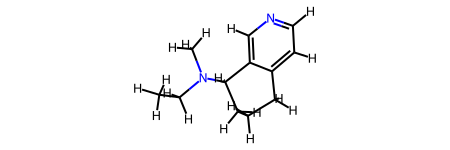

In [42]:
m3ds[0][1]

In [43]:
for mid,mh in m3ds:
    ok,res = rdEHTTools.RunMol(mh)
    if not ok:
        continue
    d = {'atomic_charges':list(res.GetAtomicCharges())}
    opm = res.GetReducedOverlapPopulationMatrix()
    bnds = []
    nats = mh.GetNumAtoms()
    for bond in mh.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        if a1<a2:
            a1,a2 = a2,a1
            
        o = opm[(a1*(a1+1))//2 + a2]
        bnds.append(o)
    d['mulliken_overlap_pops'] = bnds
    curs.execute('insert into experiments.data values (%s, %s, %s)',(qm_expt_uid,mid,json.dumps(d)))
cn.commit()

!!! Warning !!! Distance between atoms 51 and 19 (0.986362 A) is suspicious.
!!! Warning !!! Distance between atoms 43 and 11 (0.998451 A) is suspicious.


In [44]:
%sql postgresql://localhost/lwreg_experiments_demo \
    select molregno,data->>'mulliken_overlap_pops' from experiments.data \
    where experiments.data.expt_uid=:qm_expt_uid limit 10;

10 rows affected.


molregno,?column?
1,"[0.7588210854129853, 0.6960798035320421, 0.7030709648557724, 0.7193538868339985, 0.774150798589617, 0.7486630435805379, 0.7757295534979947, 0.8240735932579611, 1.0520943408018026, 1.1352782675808042, 0.9486525638689337, 0.9368013265572955, 1.1172784701723986, 0.7882606379393313, 1.1260320927153076, 0.788663147973945, 0.780929555369681, 0.7779392404840062, 0.7989484932972828, 0.7901179946034863, 0.7848156987894137, 0.7992092191106055, 0.7812049995190007, 0.8046291552644913, 0.8062814345550681, 0.799533820775415, 0.7885854135579193, 0.7924200251543123, 0.7719850380749549, 0.770171722783104, 0.8029440490205249, 0.7938294456191481, 0.8075969291587768]"
2,"[0.774911503854123, 0.7974007519937242, 0.7421931820239639, 0.7443806512437614, 0.7647854001849247, 0.7519030940366851, 0.7323103096071877, 0.7751628833479896, 0.7415006179285412, 0.8028857563168267, 1.0709100263538045, 0.6305446785232481, 0.604421236976903, 1.147074540233091, 1.0600427385605435, 1.1249442931314033, 1.0778702109274747, 0.8061807696564158, 0.7430185002100813, 0.785512546501707, 1.1456050131354911, 0.7644053700453084, 0.7920377048917417, 0.7795270529063039, 0.7799574702277807, 0.7701111450519953, 0.7587656995982754, 0.7869340761426045, 0.796840174506572, 0.7994447777940437, 0.7969731458442706, 0.7877645493045676, 0.7827835485889024, 0.7767241511879495, 0.7912992331952657, 0.8004375876511254, 0.8086474224674401, 0.8085245132654055, 0.7830442489879057, 0.7961394556213328, 0.7823003435389484, 0.7787346311596386, 0.7732368197518475, 0.7923135338198736, 0.8007966017968785, 0.7948083315521933, 0.8011183379703815, 0.7804338293820499, 0.798191811660951, 0.7738848478773526]"
3,"[0.6938095037811264, 0.7137513112497068, 0.7743770295300594, 0.6968457877277664, 0.7228526914464398, 0.7687050756798072, 0.8696945672277703, 0.9611091232928075, 0.9441633391631379, 1.101760816885246, 1.1034977607293392, 0.9425235578949482, 0.8354783810865715, 1.195533583163416, 0.8981860310459817, 0.9782750256059157, 0.9820376585442234, 0.9080167405001632, 1.0918218272768696, 1.0907661160510413, 1.1052692160022668, 1.0923749488790462, 1.1079475429191092, 0.7204253489794624, 0.9553617925627014, 0.8902629093666007, 1.077609839315123, 0.7742410109754332, 0.7876768119487396, 0.7936814626175499, 0.7732828083125542, 0.7812682457304935, 0.7878129936496628, 0.7801486538266198, 0.7843401626954423, 0.7962185791761798, 0.7772021254275813, 0.7904406088489522, 0.790531200111451, 0.8011279260448956, 0.7982149226393346, 0.7025822993791397, 0.8056343621773251, 0.7924877655243366, 0.7963306731514601, 0.7964253291494335, 0.8084497275059398]"
4,"[0.7712548395695309, 0.7542917927825599, 0.7126346263132948, 0.7083553491316641, 0.7761149902524034, 0.7382986483097811, 0.7868954377922771, 0.794918322392599, 0.7478462979845351, 0.7931774102258639, 1.104241731494547, 1.095950654922912, 1.0699263693193457, 0.9639063279657902, 1.214584601868207, 0.736295271685004, 0.7228481918714987, 1.0886464002516756, 0.7308632330167328, 0.8247968432346587, 1.1286360947883716, 1.1003008568515018, 0.7702962440477982, 0.7788451336009682, 0.7949374603591409, 0.7806697796478443, 0.7960799042302197, 0.7912208458563902, 0.79983248010577, 0.7909825017102383, 0.7944061807294913, 0.7980716504930876, 0.7938447604719843, 0.7881142409217655, 0.7949631610514396, 0.7938040006051386, 0.7882526757601083, 0.7910479940103801, 0.781968177309874, 0.8032607317858611, 0.7995578321327544, 0.799310771795418, 0.7962316079472732]"
5,"[0.576224777994397, 0.6160123149378874, 1.110588288640848, 1.0940231506011444, 1.087911266692821, 1.1193422204892145, 0.6043558964149478, 0.5662200170819174, 0.8012183624872663, 0.7870291409731206, 0.7275286742112098, 0.6761716316342347, 0.7995233244634663, 0.7499665754769174, 0.7686640222463181, 0.7990174300640809, 0.807027403068359, 0.5637627690524396, 0.8005515203736366, 0.7759542532733601, 1.159536994215805, 0.7766405018918688, 0.7713857653713801, 1.080663941624549, 1.0939891595784668, 1.0789914194982393, 1.144979

Max Mulliken overlap population in each molecule

In [45]:
%sql postgresql://localhost/lwreg_experiments_demo \
  select molregno,max(bo::float) from experiments.data,\
    jsonb_array_elements(data->'mulliken_overlap_pops') with ordinality arr(bo,idx) \
    where expt_uid=:qm_expt_uid group by molregno;

10 rows affected.


molregno,max
8,1.1344083730379977
10,1.1553488924076716
9,1.2434930782393356
7,1.1497511000047735
1,1.1352782675808042
5,1.159536994215805
4,1.214584601868207
2,1.147074540233091
6,1.217363709724021
3,1.195533583163416


Max and min charges in each molecule

In [46]:
%sql postgresql://localhost/lwreg_experiments_demo \
  select molregno,max(q::float),min(q::float) from experiments.data,\
    jsonb_array_elements(data->'atomic_charges') with ordinality arr(q,idx) \
    where expt_uid=:qm_expt_uid group by molregno;

10 rows affected.


molregno,max,min
8,0.44516900085739053,-0.7809297596432287
10,0.5233252282489422,-0.8801320235439563
9,0.639263696220022,-0.7619058660693274
7,0.5702907600636768,-0.8838589477665888
1,0.3210692035320335,-0.8346751638651995
5,0.5170544059409743,-0.8421302590480964
4,0.4054796608916149,-0.6334188848836144
2,0.44439125775232924,-0.7182056946615631
6,0.4328597837576069,-0.6142212669793095
3,0.921604479447378,-0.9802933954102797


Extract the arrays directly

In [47]:
d = %sql postgresql://localhost/lwreg_experiments_demo \
  select molregno,data->'atomic_charges' \
    from experiments.data where expt_uid=:qm_expt_uid;
d[0][1]

10 rows affected.


[-0.06590088904479785,
 0.23134220701194863,
 -0.617167913893411,
 0.18179706474711566,
 0.2714988653046362,
 -0.04561805405865016,
 -0.02377397464984199,
 0.006780304737958431,
 0.16562310168241012,
 -0.0956823291079445,
 0.30881714862022136,
 -0.8346751638651995,
 0.3210692035320335,
 -0.00012562265862925415,
 0.022327371755636705,
 0.012741876709696953,
 0.011127053863674519,
 0.0055389123162967735,
 -0.0029148426838219166,
 0.0016839440904732328,
 0.018231994036113974,
 0.00093978809309192,
 -0.01483513651692192,
 0.016241420173173537,
 0.007952465448852308,
 0.002643726173118921,
 0.009555949809282538,
 0.007053282872220734,
 0.017700073436571984,
 0.031014579857696845,
 0.019368644631867937,
 0.029644786513017607]

Note that the above is a string, *not* a list

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('tableau-colorblind10')


Plot C-C overlap population vs distance for these molecules

In [49]:
import ast

rows = %sql postgresql://localhost/lwreg_experiments_demo \
    select molregno,data->>'mulliken_overlap_pops' from experiments.data \
    where experiments.data.expt_uid=:qm_expt_uid limit 10;
cc_mops = []
cc_dists = []
cc_bos = []
for mrn,mops in rows:
    mops = ast.literal_eval(mops)
    mol = None
    for tpl in m3ds:
        if tpl[0]==mrn:
            mol = tpl[1]
            break
    assert mol is not None
    conf = mol.GetConformer()
    for idx,mop in enumerate(mops):
        bnd = mol.GetBondWithIdx(idx)
        if bnd.GetBeginAtom().GetAtomicNum()==6 and bnd.GetEndAtom().GetAtomicNum()==6:
            dist = (conf.GetAtomPosition(bnd.GetBeginAtomIdx())-conf.GetAtomPosition(bnd.GetEndAtomIdx())).Length()
            cc_mops.append(mop)
            cc_dists.append(dist)
            cc_bos.append(bnd.GetBondType())
    

10 rows affected.


In [50]:
from collections import defaultdict
cc_dists_1 = defaultdict(list)
cc_mops_1 = defaultdict(list)
for bo,d,mop in zip(cc_bos,cc_dists,cc_mops):
    cc_dists_1[bo].append(d)
    cc_mops_1[bo].append(mop)
        

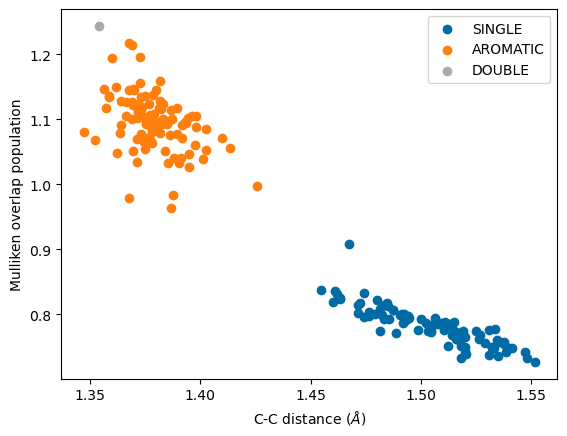

In [51]:
for k in cc_dists_1.keys():
    plt.scatter(cc_dists_1[k],cc_mops_1[k],label=str(k))
plt.legend()
plt.xlabel('C-C distance ($\AA$)')
plt.ylabel('Mulliken overlap population');